# Example notebook with csv export

You can use this notebook as a template for some of your own simulations. In general, I would strongly urge you to start the notebooks for your research from scratch, rather than just editing a notebook that was set up for some other example. That way, you will be forced to make sure that all the steps in the notebooks make sense. Generally it also helps to have some consistent structure to your notebooks.

Make use of the notebooks abilities to document what you are doing, so add text and comments as needed. You can even add equations (see jupyter notebook help).

## Import modules and set some default settings

I typically start my notebook with an import of all the modules that I will be using anyway. I also use the same aliases every time, to make it easier to follow what I am doing:

In [1]:
%matplotlib inline
import pysumma as ps
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import seaborn as sns # a module that adds some plotting capabilities and makes your plots look better
import pandas as pd # an excellent time series package that we'll use to write some csv files

In [2]:
sns.set() # activates some of the default settings from seaborn
# The following settings just set some defaults for the plots
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['axes.labelsize']  = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.dpi'] = 200

## Test location: Harvard

In this example I will use the Harvard site from the PLUMBER setup as the test location. Install this site using the `/home/jovyan/cewa564/install_summa_model_configurations.ipynb` notebook if you have not already done so.

Set the path to the SUMMA file manager file for the Harvard site"

In [3]:
filemanager_path = '/home/jovyan/PLUMBER_data/sites/Harvard/settings/summa_zFileManager_Harvard.txt'

## Test simulation

Create a SUMMA simulation object and do a test simulation:

In [4]:
S = ps.Simulation(executable='summa.exe', filemanager=filemanager_path)

In [5]:
S.start(run_option='local', run_suffix='test')
S.monitor()

False

You can access the output as `S.output`. However, you don't need to rerun every time to get this output. You can also read the output file directly into an xarray DataSet. The path of the output file can be found as `S._output()`. We'll show how to read the output directly later in this notebook.

## Accessing and plotting scalar variables

You can quickly plot some of the model output using built-in plotting functions. To see what you have available in the output file, simply type `S.output` and hit `Shift-Enter`:

In [6]:
S.output

<xarray.Dataset>
Dimensions:                  (gru: 1, hru: 1, ifcSoil: 10, ifcToto: 15, midSoil: 9, midToto: 14, time: 140256)
Coordinates:
  * time                     (time) datetime64[ns] 1994-01-01T00:30:00.000013408 ... 2002-01-01
  * hru                      (hru) int32 1
Dimensions without coordinates: gru, ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                  (time, hru) float64 ...
    airtemp                  (time, hru) float64 ...
    hruId                    (hru) int32 ...
    basin__SurfaceRunoff     (time, gru) float64 ...
    basin__ColumnOutflow     (time, gru) float64 ...
    basin__AquiferStorage    (time, gru) float64 ...
    basin__AquiferRecharge   (time, gru) float64 ...
    basin__AquiferBaseflow   (time, gru) float64 ...
    basin__AquiferTranspire  (time, gru) float64 ...
    averageInstantRunoff     (time, gru) float64 ...
    averageRoutedRunoff      (time, gru) float64 ...
    nSnow                    (time, hru) int32 ...
    nS

All the variables that vary only along the `time` and `hru` dimensions can be plotted by just typing:

`S.output.<variable>.plot()`

because there is only one hru in this case. Remember that Jupyter notebooks can reduce the amount of typing that you need to do. Just hit `tab` to complete things.

/srv/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


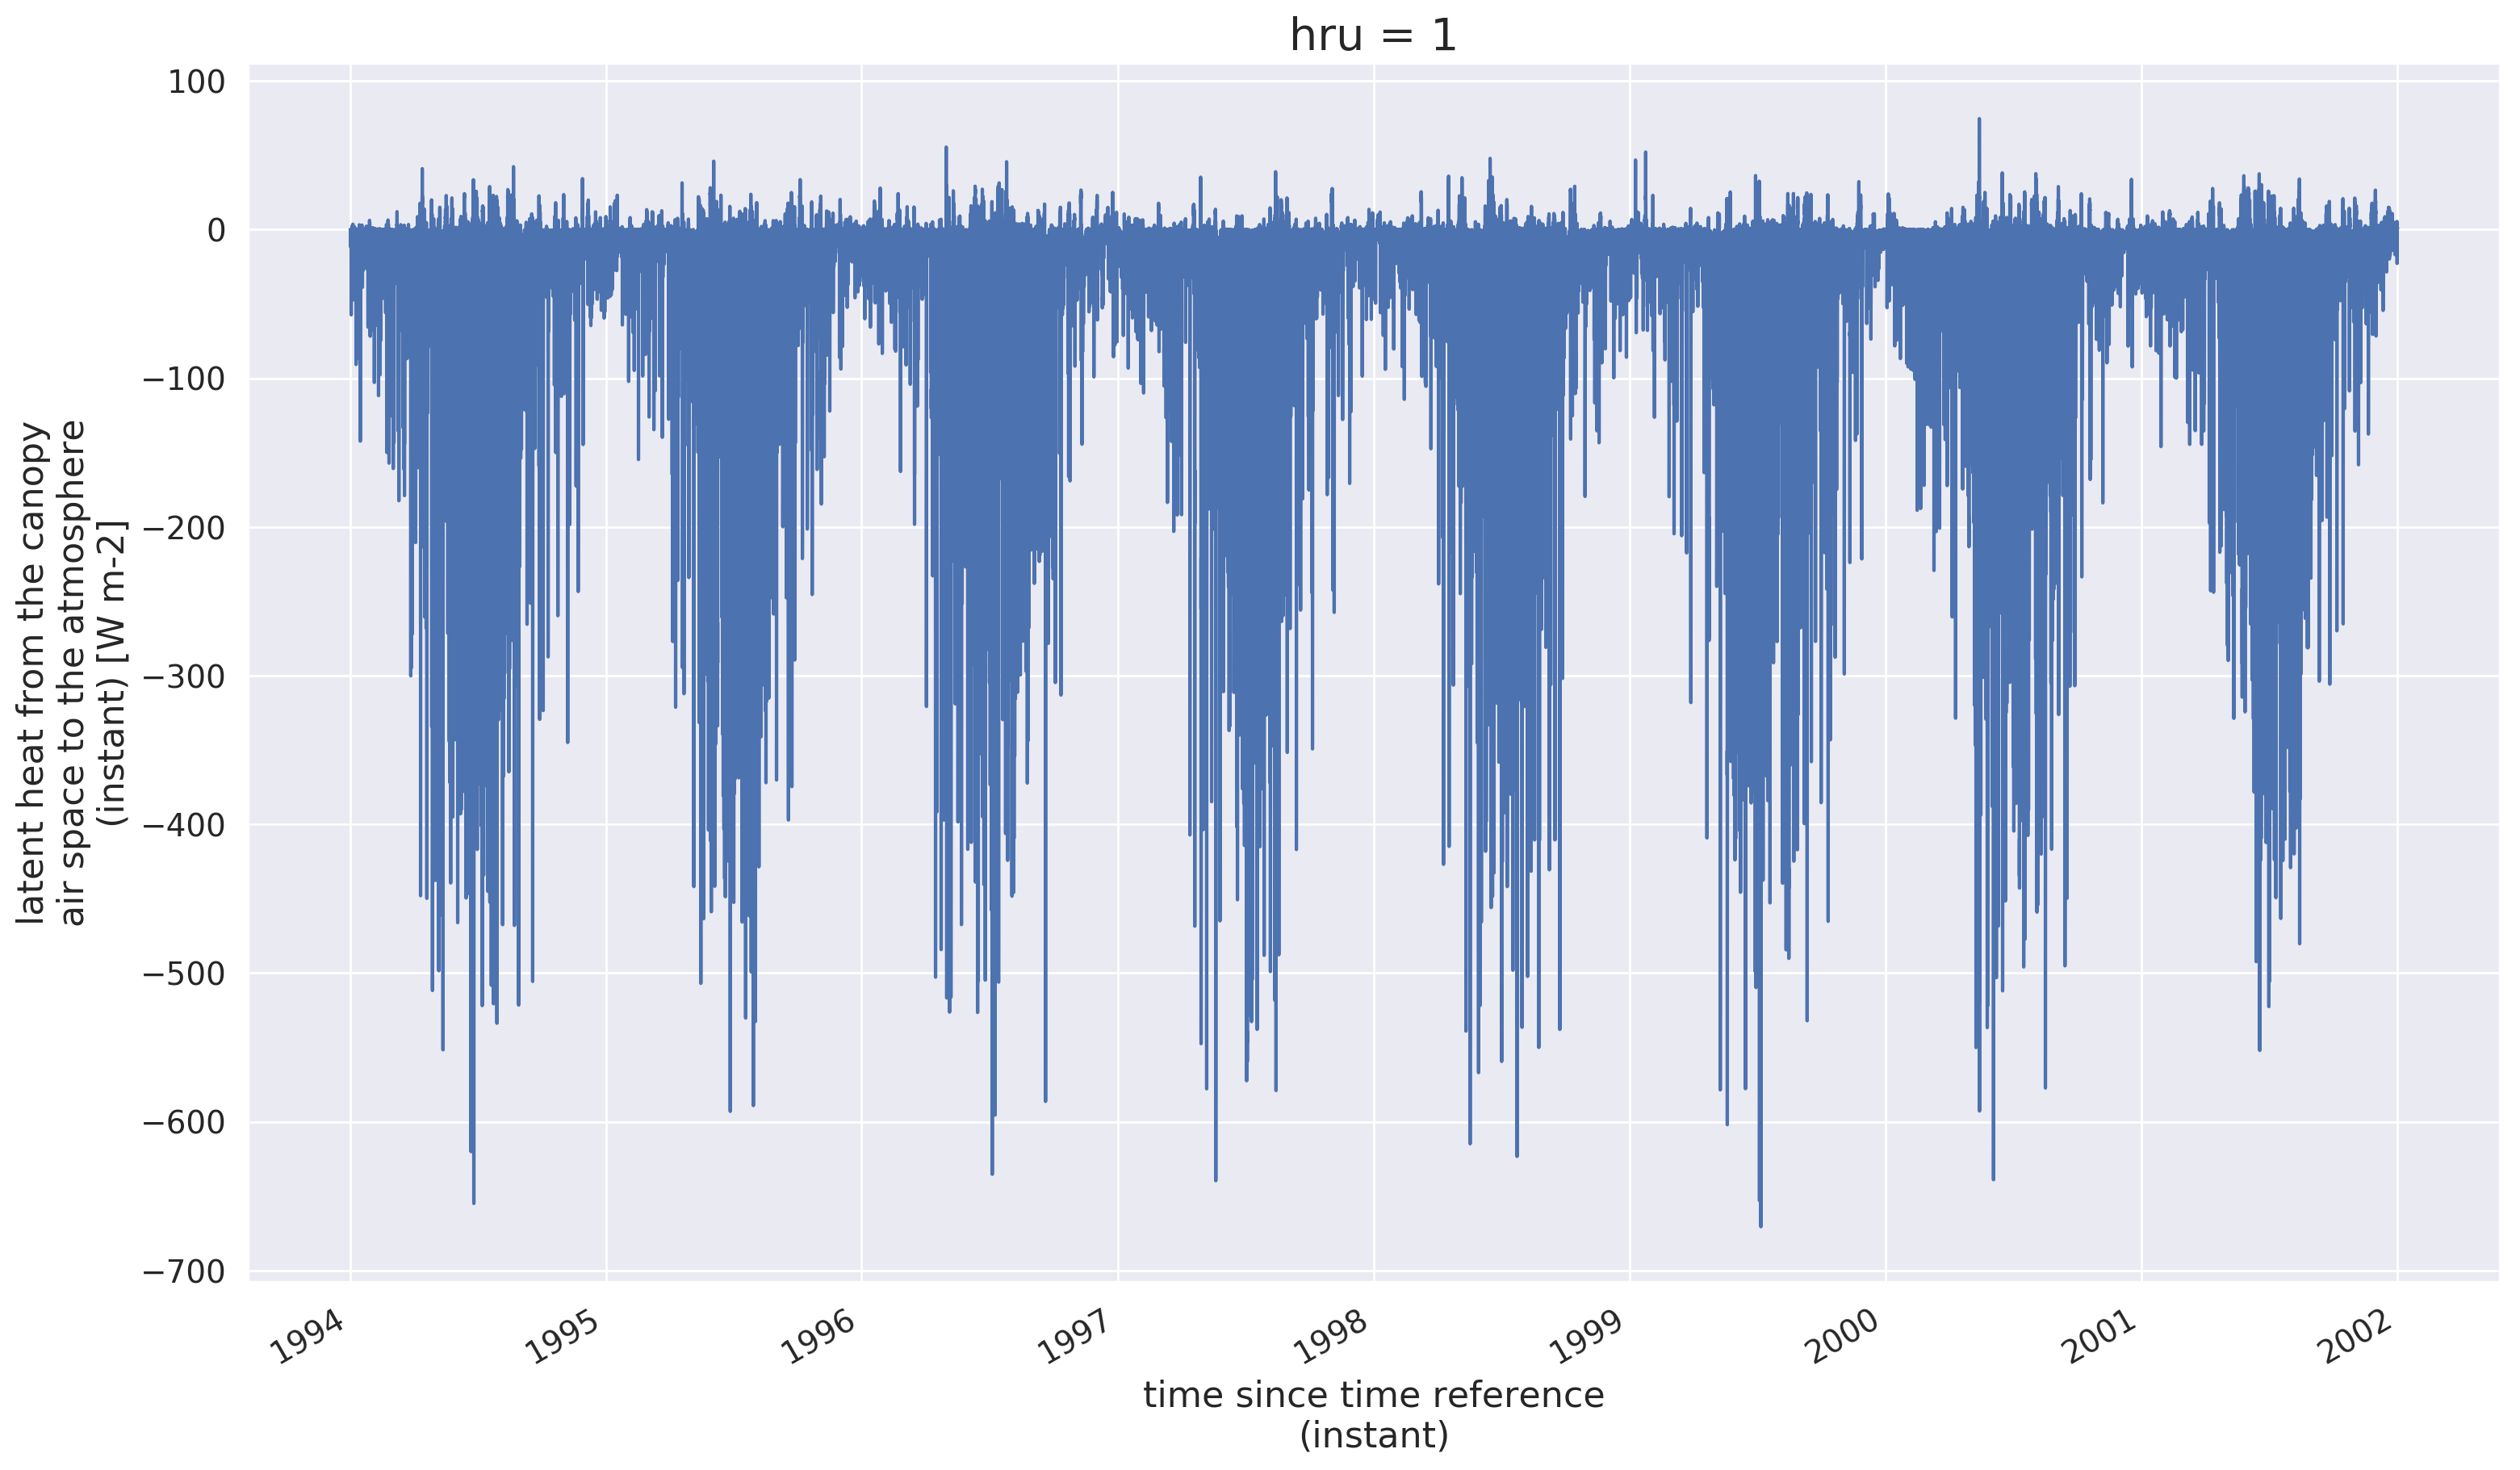

In [7]:
S.output.scalarLatHeatTotal.plot()

## Accessing and plotting variables that vary with depth

A number of the output variables vary not just with `time`, but also with each soil and or snow layer. A quick note on terminology:

`midToto` - indicates that the variable dimension includes both soil and snow layers and that the value represents the middle of the layer<br>
`midSoil` - indicates that the variable dimension includes only soil layers and that the value represents the middle of the layer<br>
`midSnow` - indicates that the variable dimension includes only snow layers and that the value represents the middle of the layer

`ifcToto` - indicates that the variable dimension includes both soil and snow layers and that the value represents the interface between the layers<br>
`ifcSoil` - indicates that the variable dimension includes only soil layers and that the value represents the interface between the layers<br>
`ifcSnow` - indicates that the variable dimension includes only snow layers and that the value represents the the interface between the layers

Layers are ordered from top to bottom and you have to keep in mind that the first layer is addressed as `0`. For variables that vary along one of the `*Toto` dimensions, you have to be careful to account for the (potentially) varying number of snow layers. Note that there are `nSnow` and `nSoil` variables that keep track of the number of layers as a function of time.

For example, if you want to plot the soil moisture content (ice and liquid) of the top soil layer, then the variable you are interested in is `mLayerVolFracWat`, which varies along the dimensions `(time, midToto, hru)`. There is only one HRU here, so that is easy.

For the Harvard site, the number of snow layers for the default configuration varies as:

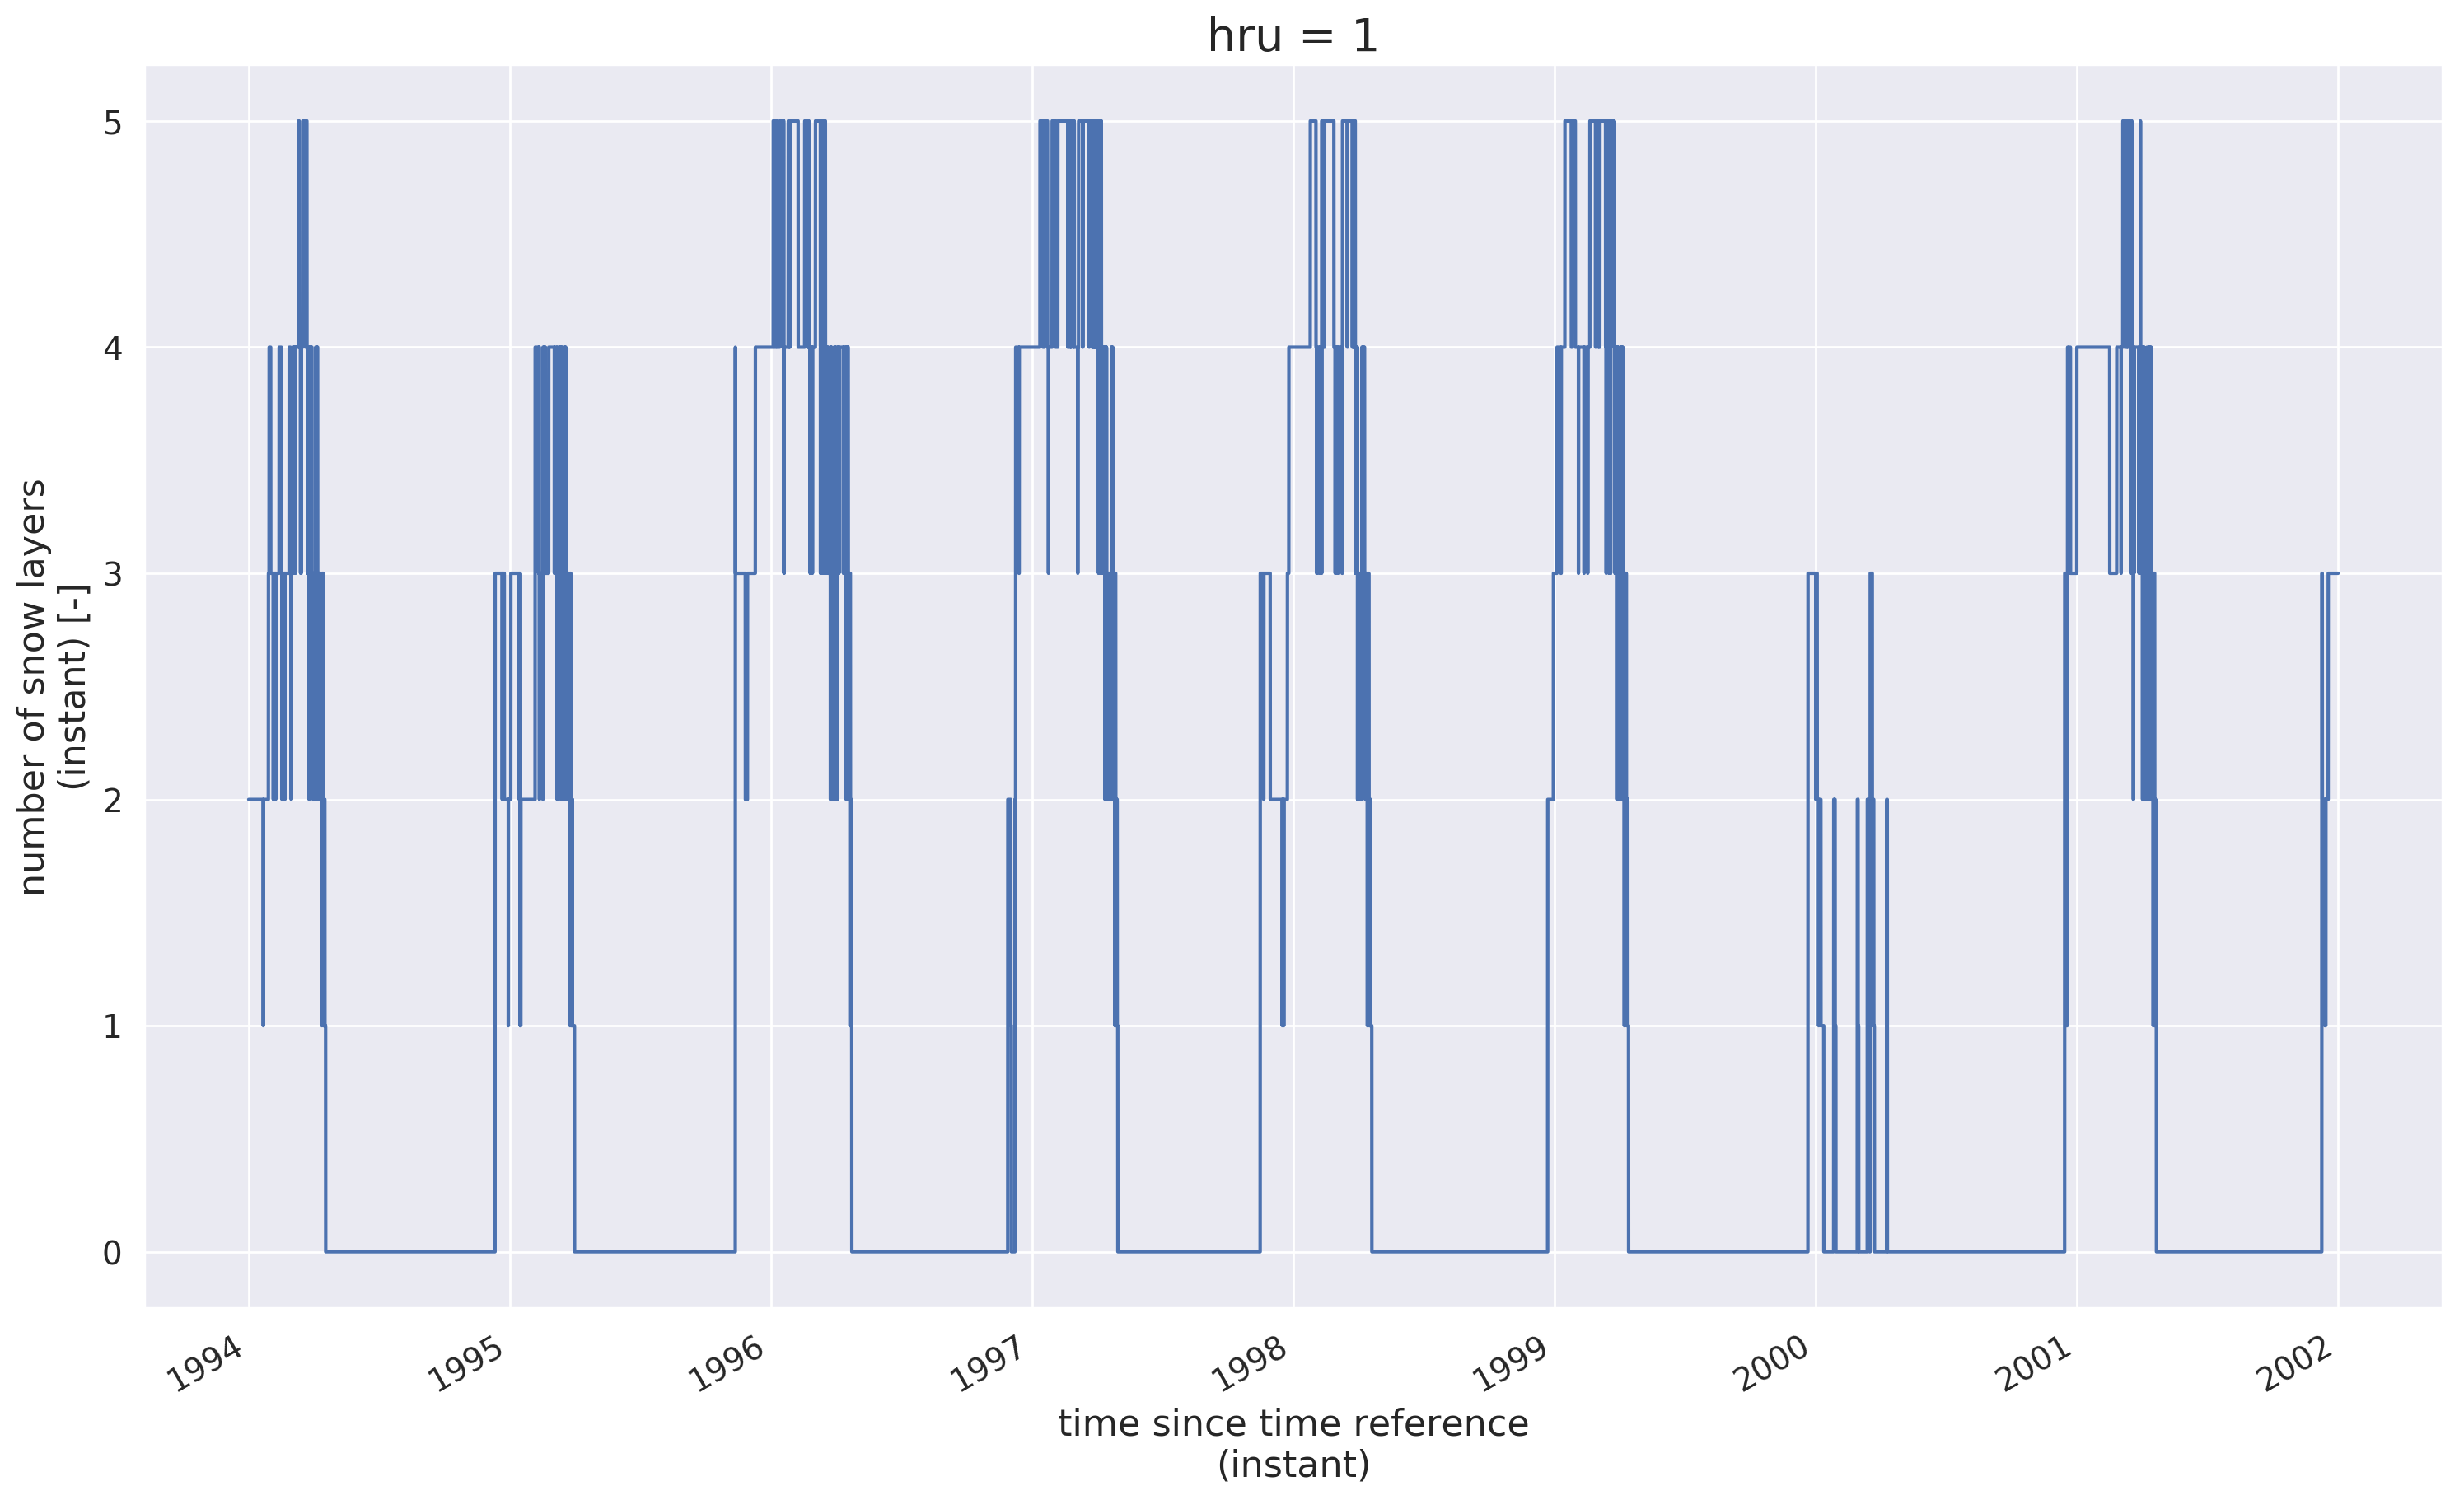

In [8]:
S.output.nSnow.plot()

Note that that will change if you select a different snow layering scheme. If you just plot the `mLayerVolFracWat` variable, you will get something like

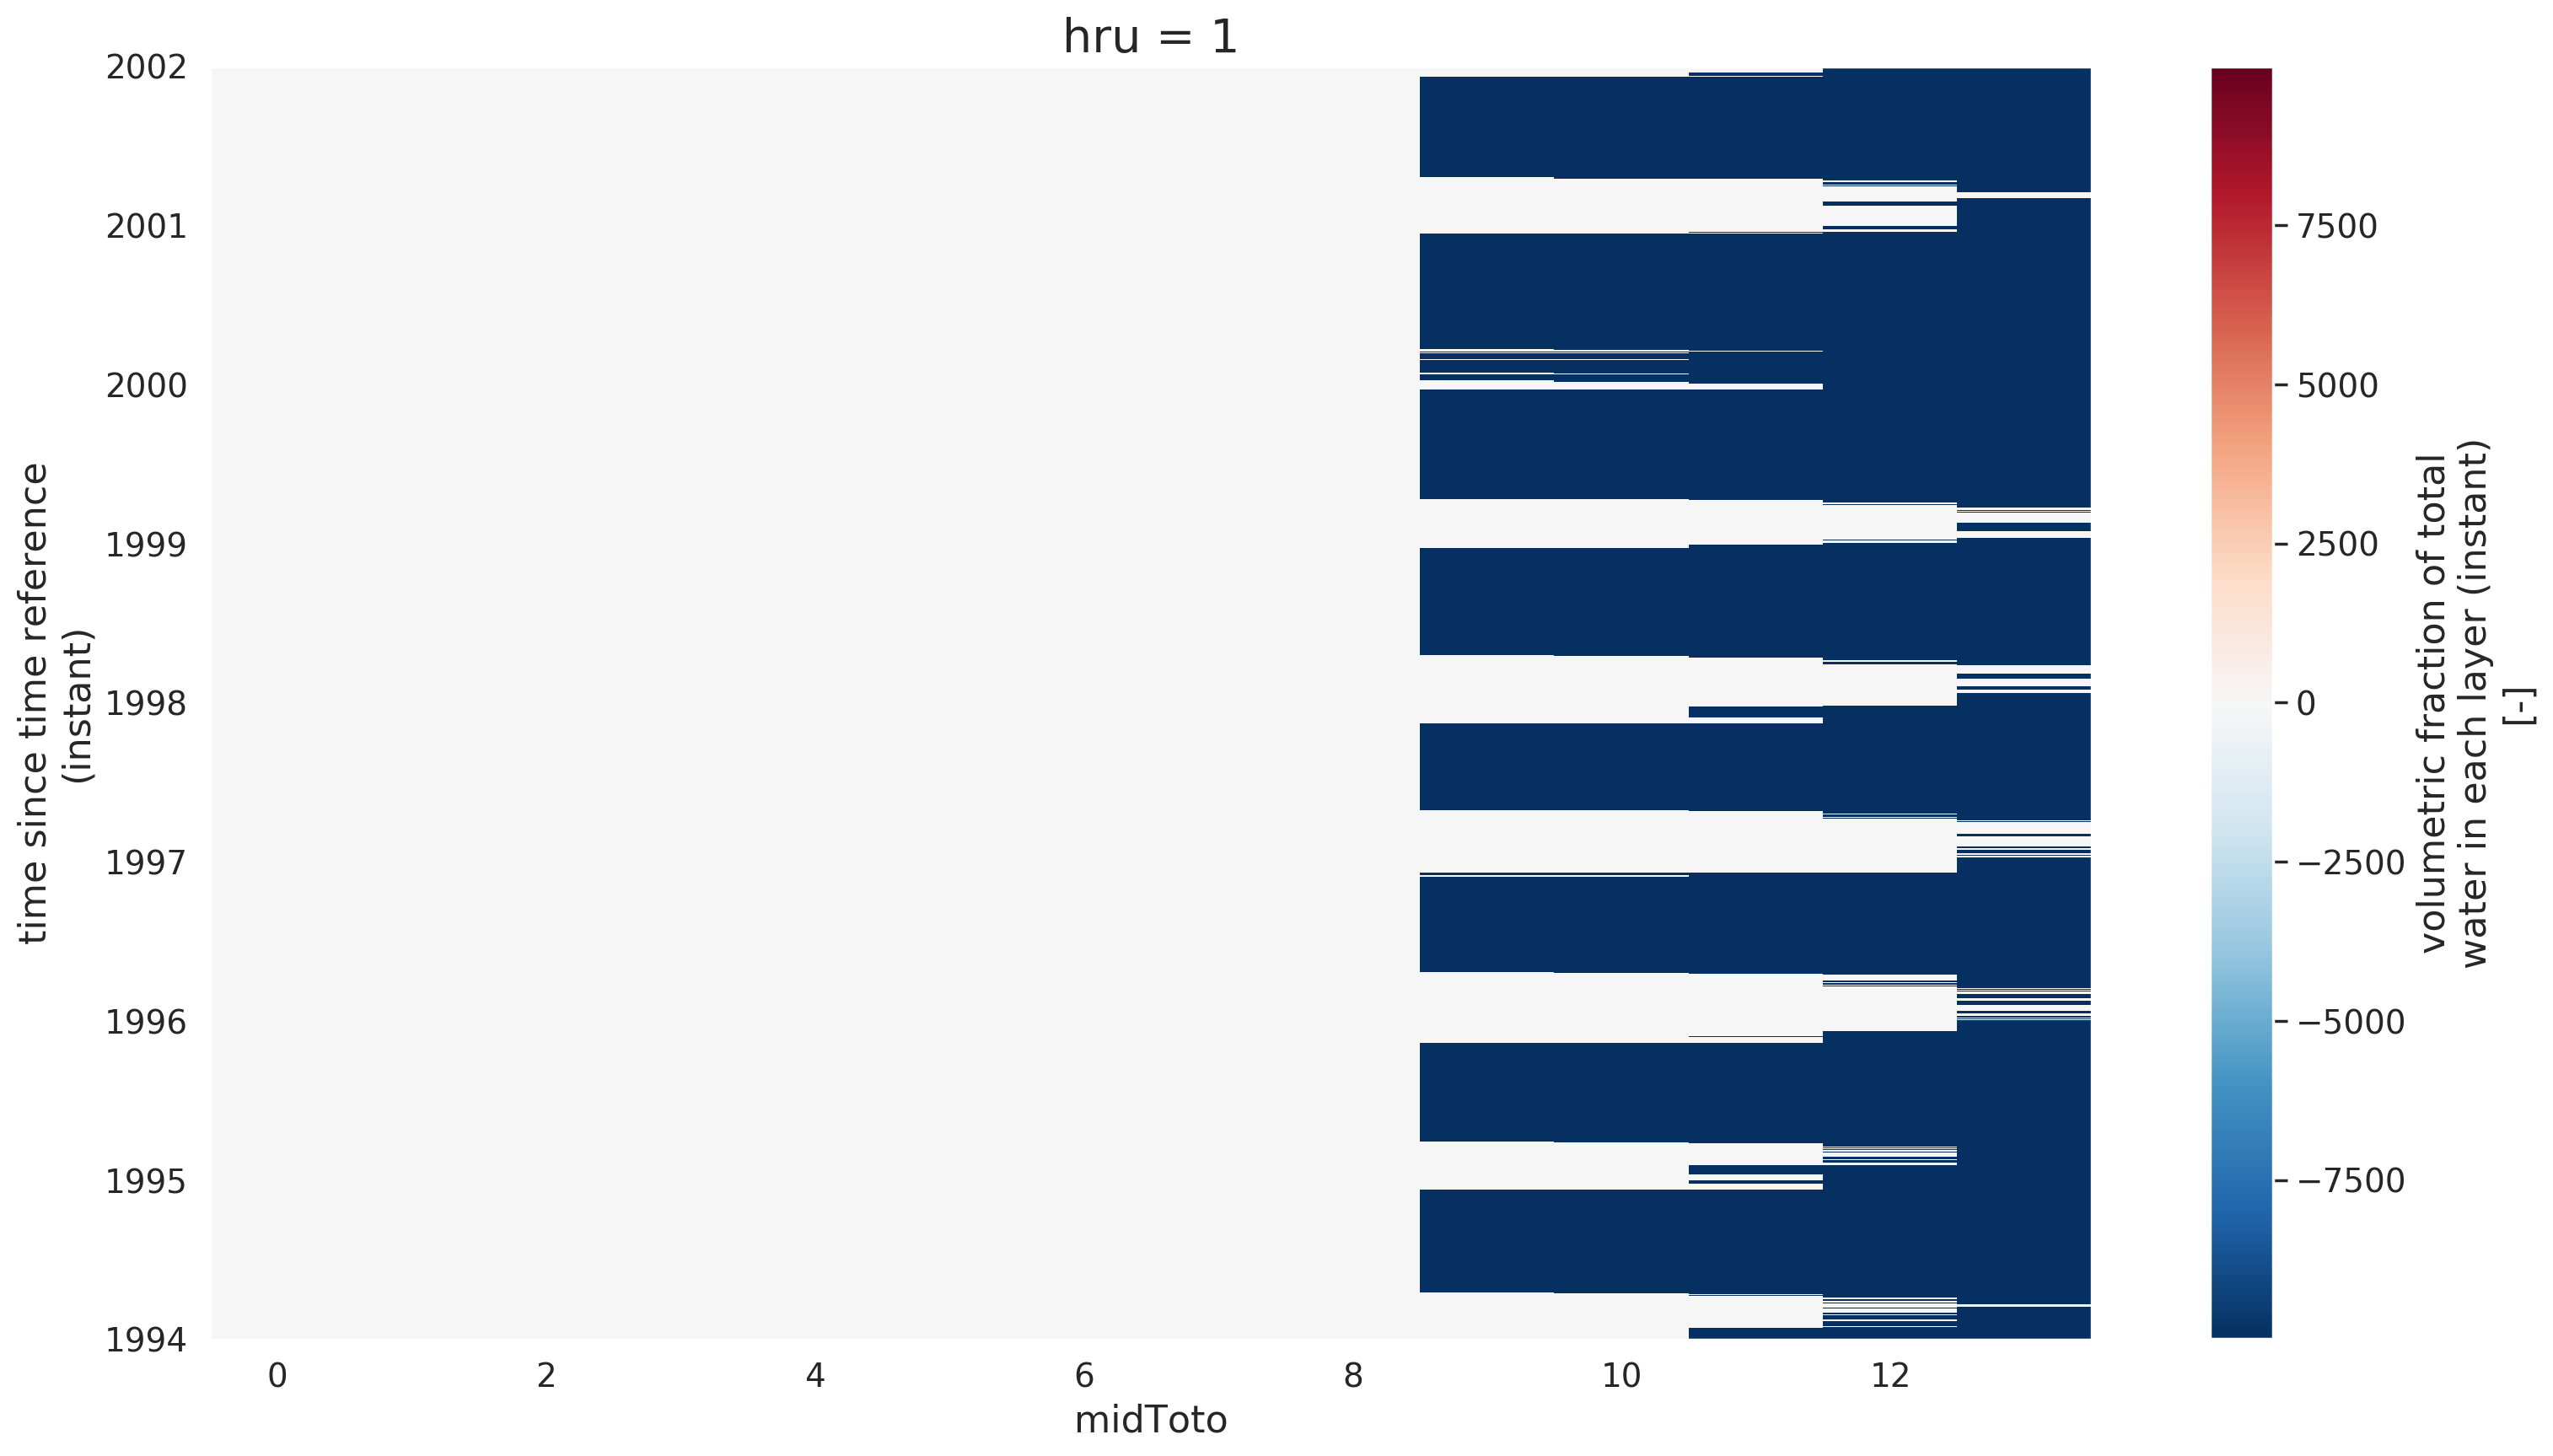

In [9]:
S.output.mLayerVolFracWat.plot()

which looks odd. The first problem is that SUMMA reports non-existing values as -9999. So we really should set these to `NaN`. We can do that in xarray:

In [10]:
S.output['mLayerVolFracWat'] = S.output.mLayerVolFracWat.where(S.output.mLayerVolFracWat>-9999.)

Now if we plot it

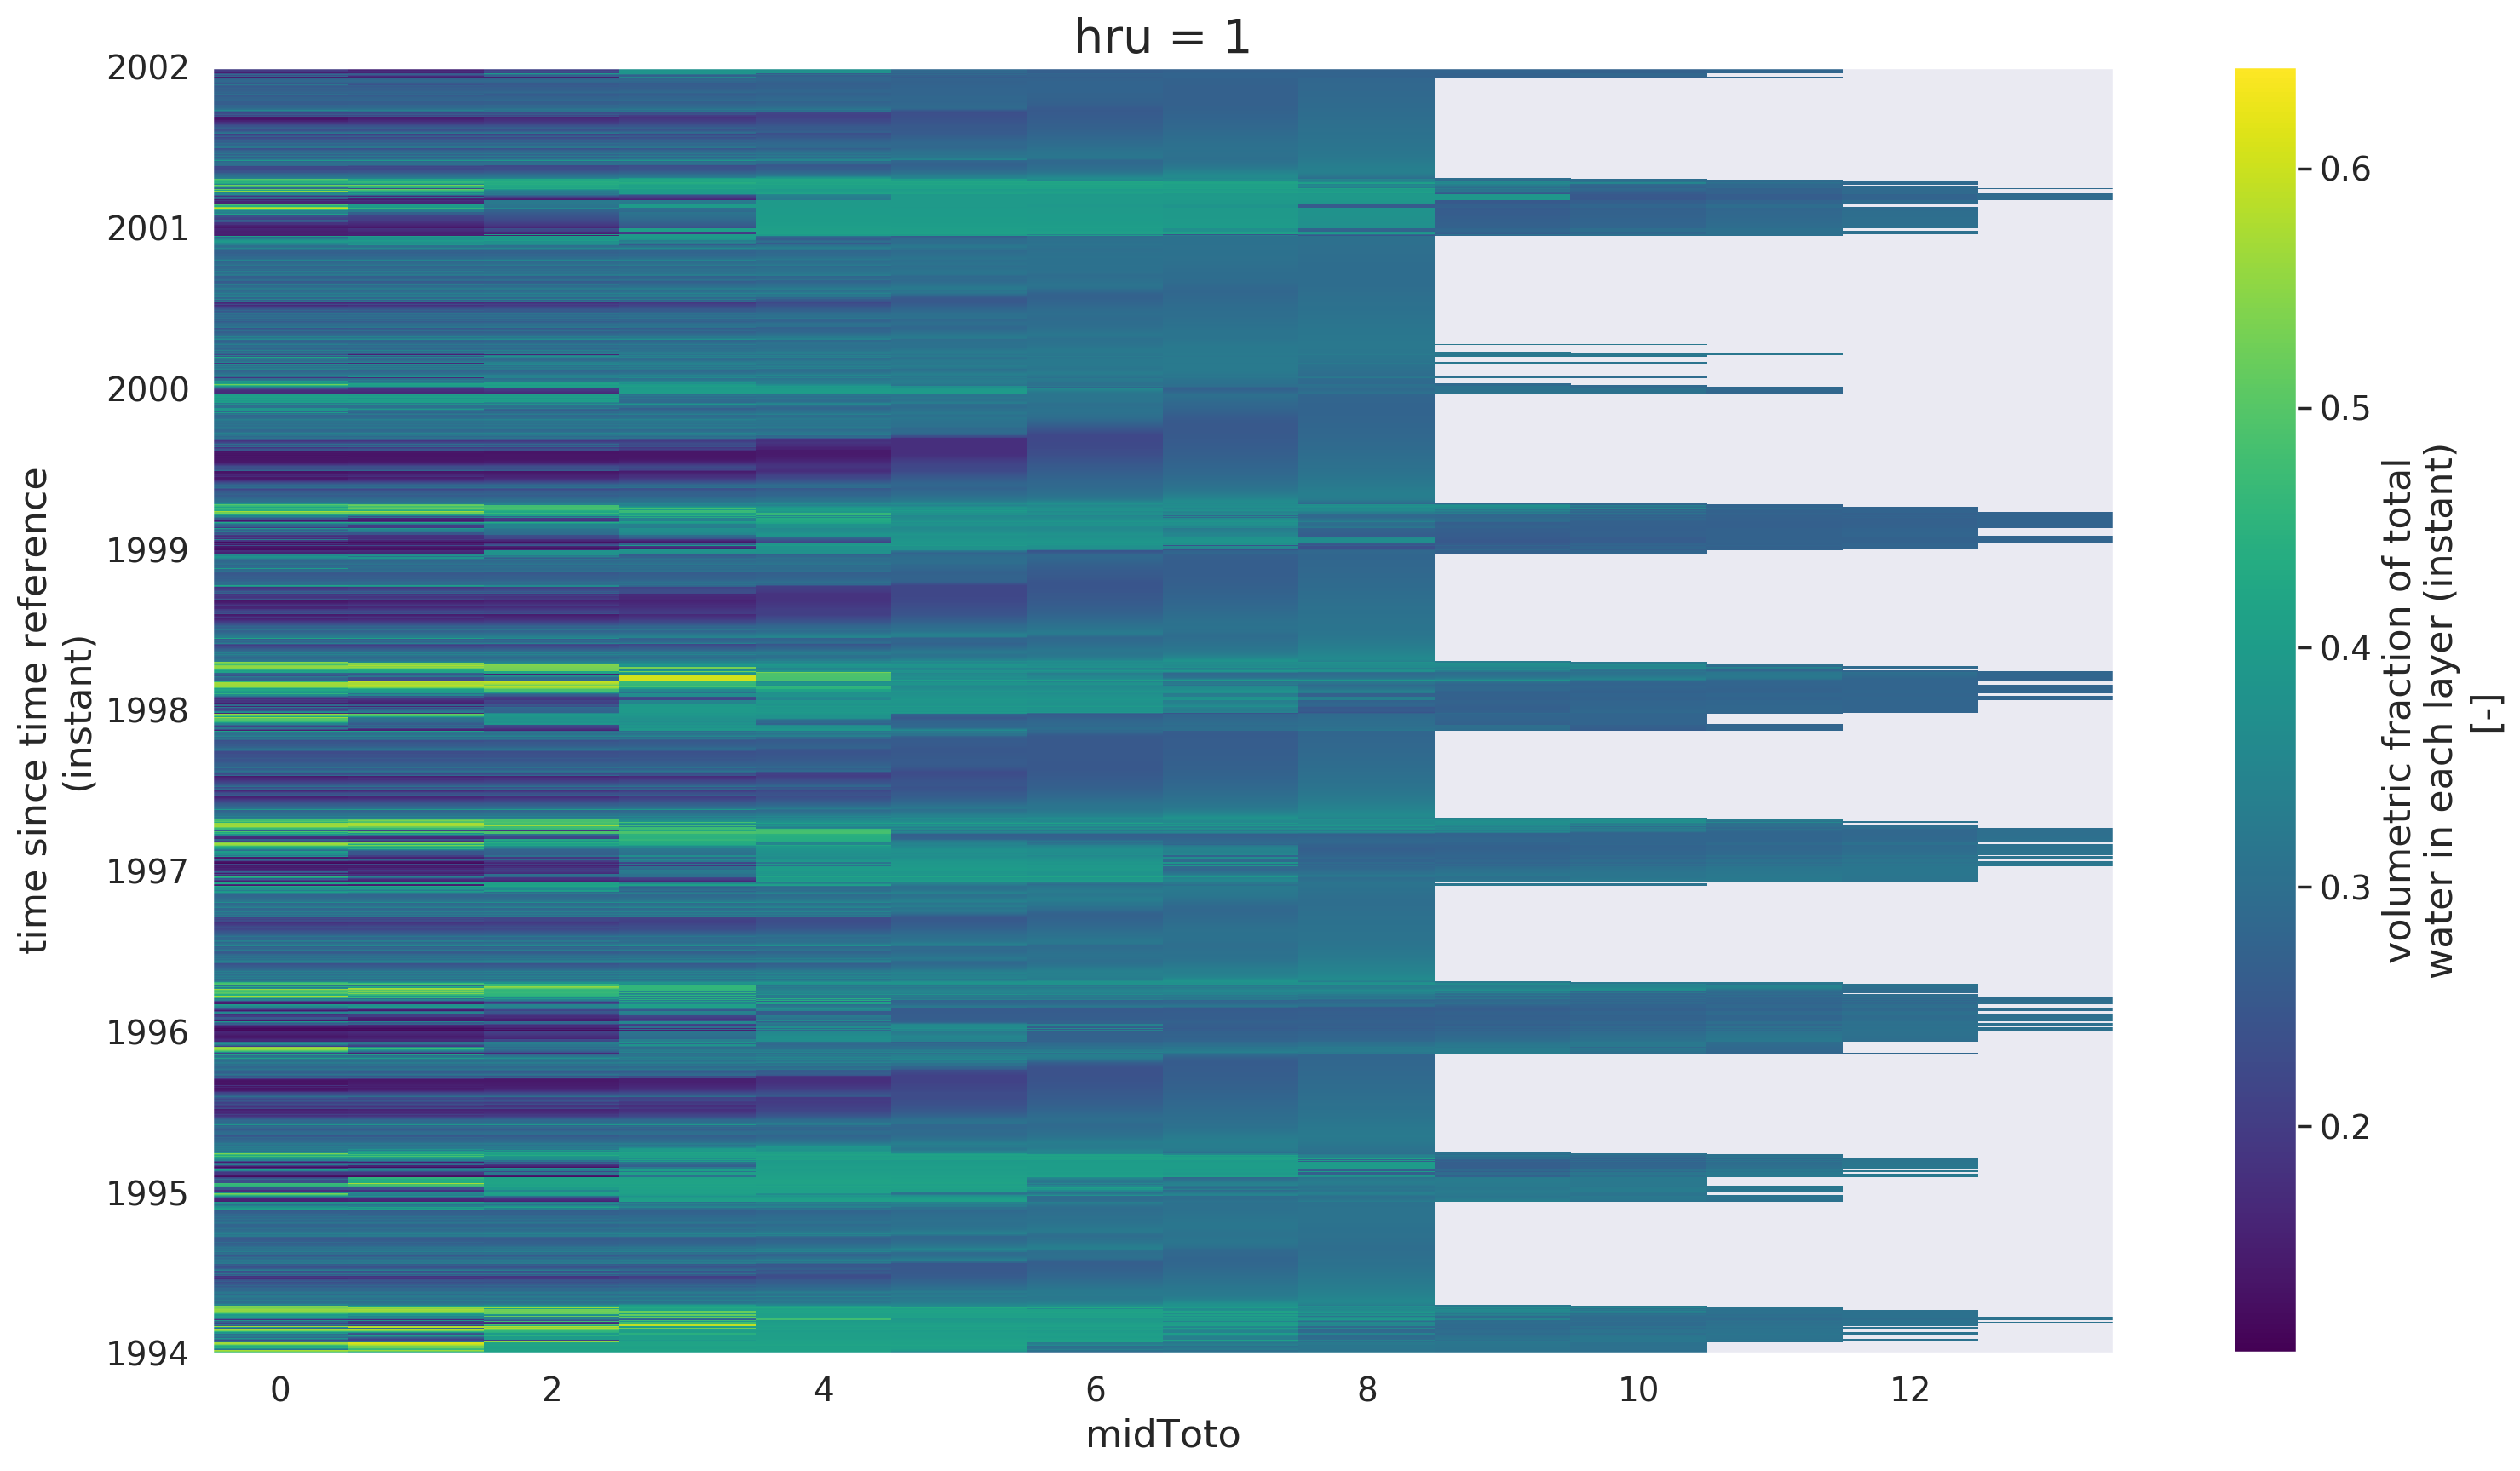

In [11]:
S.output.mLayerVolFracWat.plot()

You actually get a 2-D plot with soil moisture in each soil and snow layer. I will share a snippet of code later to show you how you can combine this with information about the depth of each layer to create a 2-D plot that reflect the correct layer depth (note that the depth of each layer is represented in `S.output.mLayerDepth`.

To extract the soil moisture content in the top soil layer (0), you can use:

Text(0, 0.5, 'Volumetric fraction of total water in top soil layer (-)')

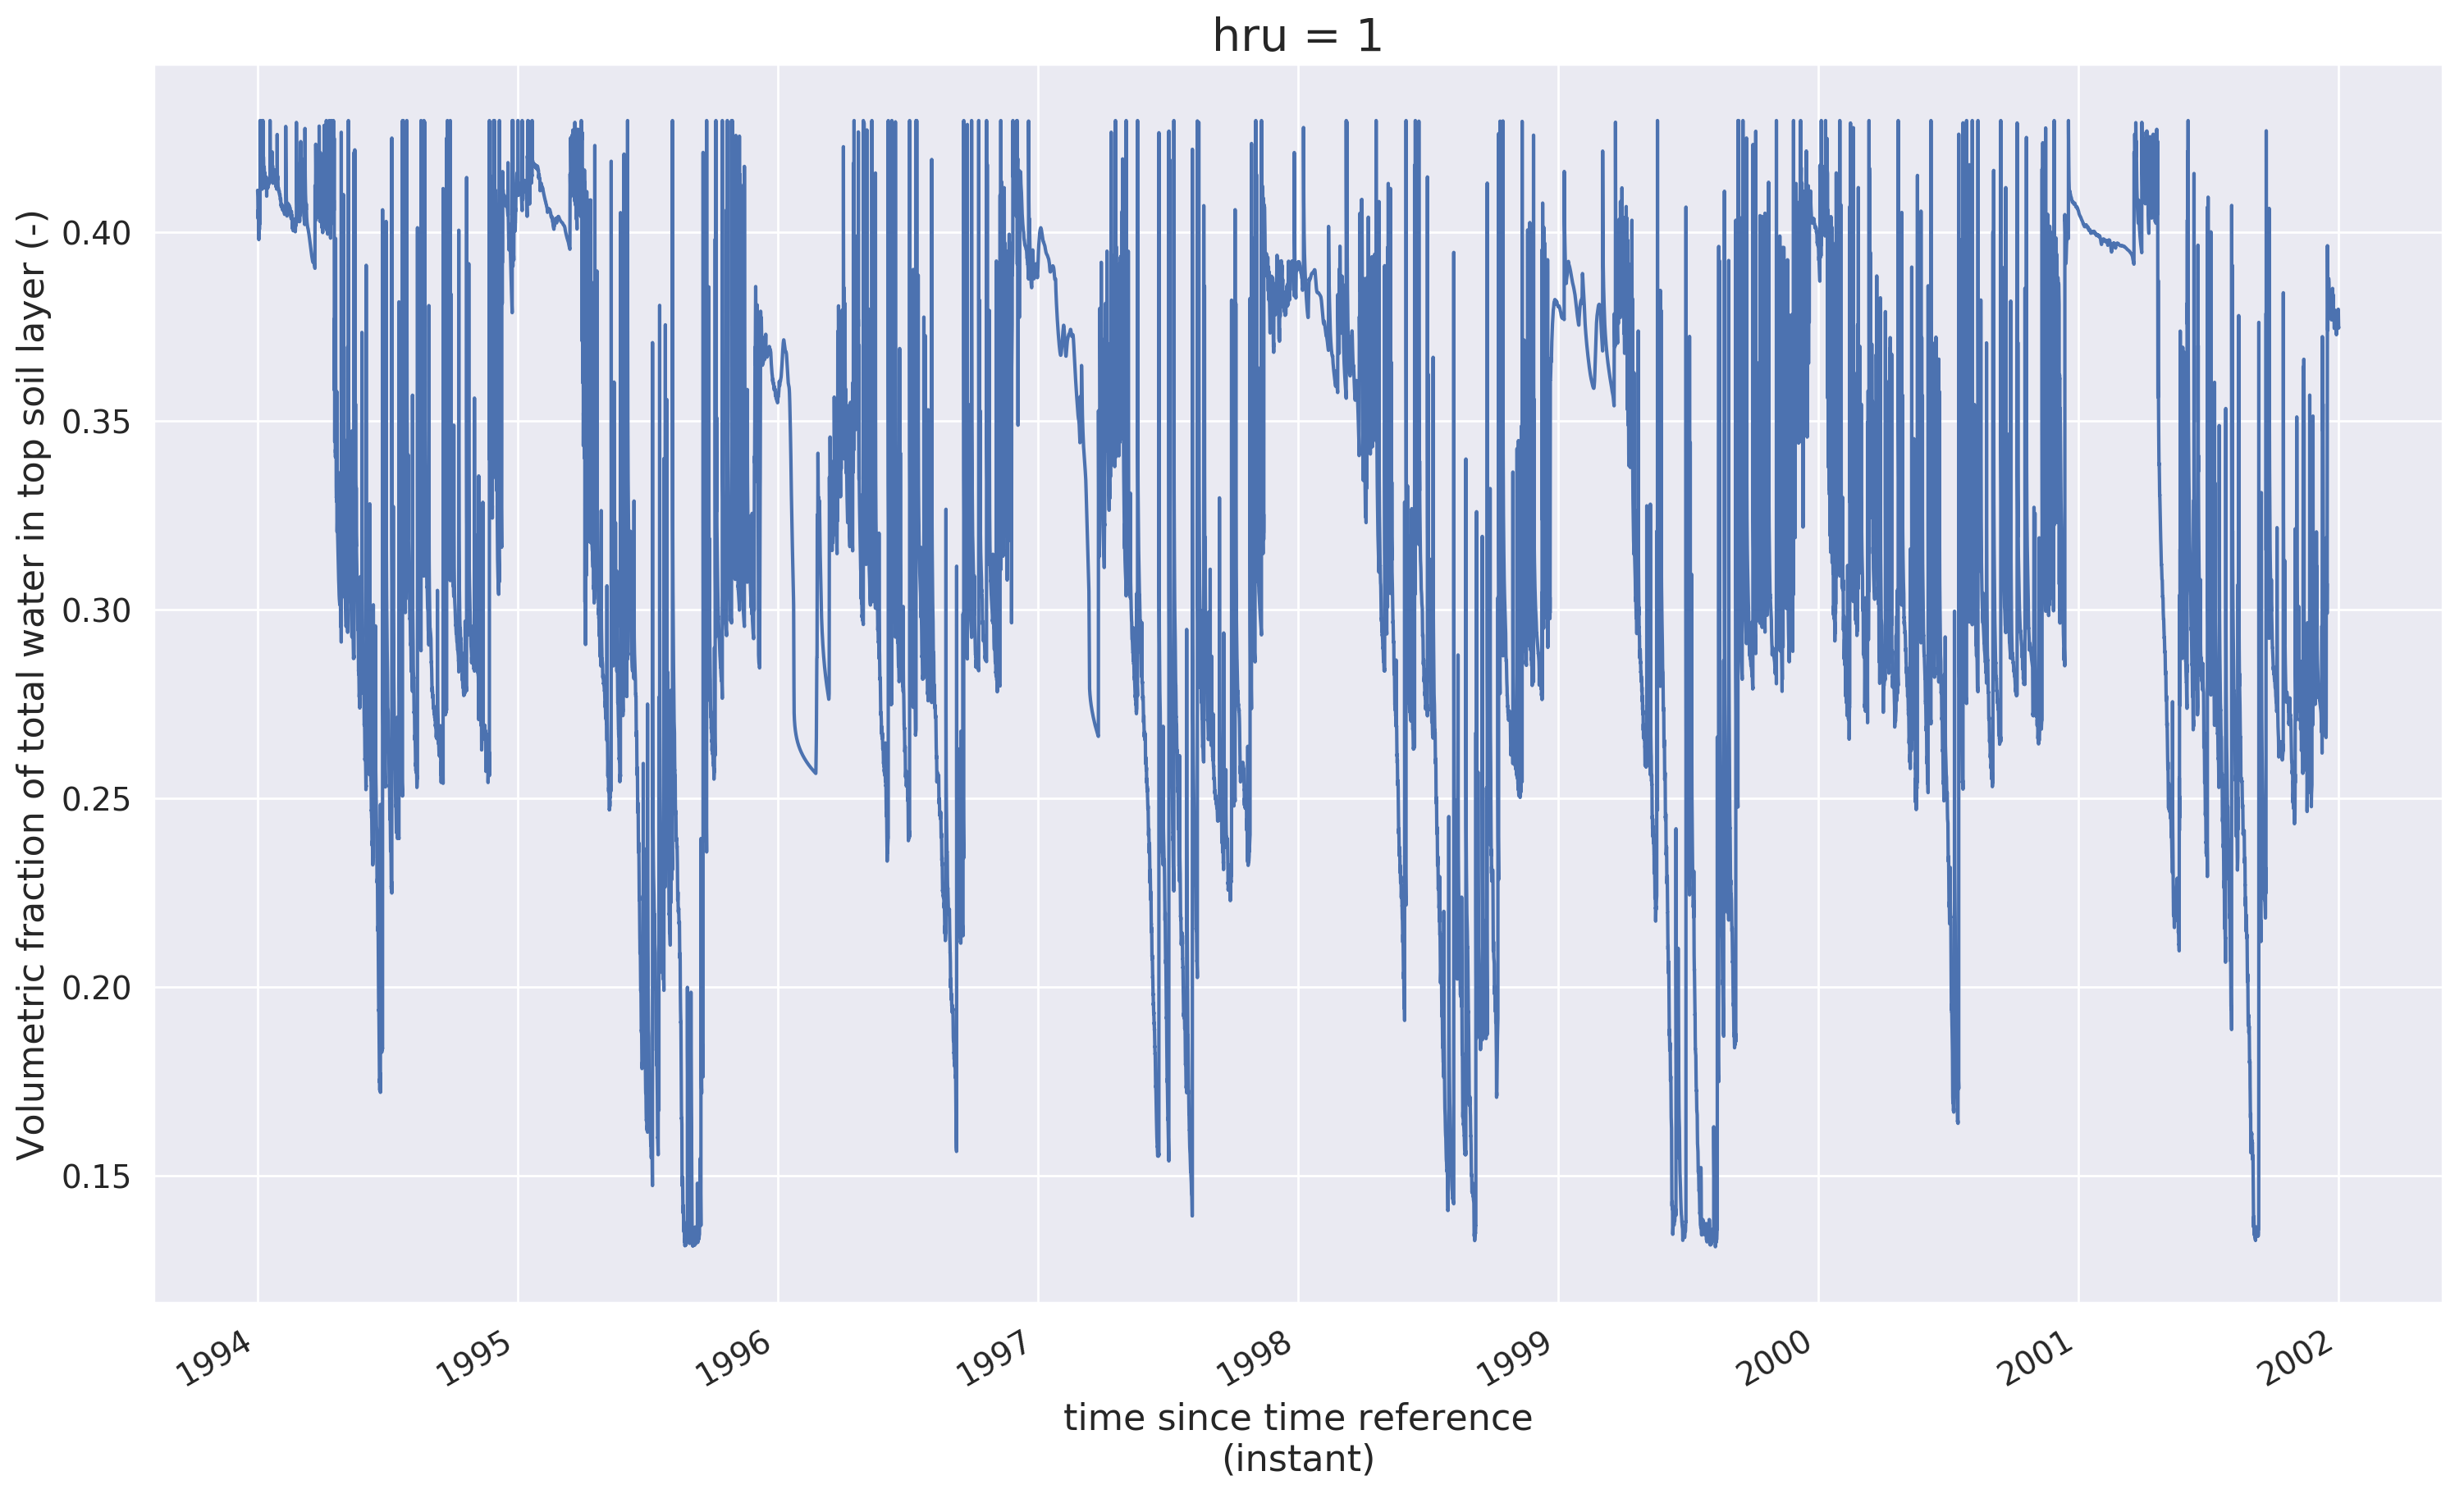

In [12]:
soil_layer = 0 # top soil layer
snow_layers = S.output.nSnow
toto_layer = soil_layer + snow_layers
S.output.mLayerVolFracWat[:,toto_layer].plot()
plt.ylabel('Volumetric fraction of total water in top soil layer (-)')

Note that in this case we are selecting for `[:,toto_layer]`, which means _ALL_ time steps (the first dimension) and only the `toto_layer`. Similarly, the total number of soil layers is 9 for this site (this may vary among the different setups)

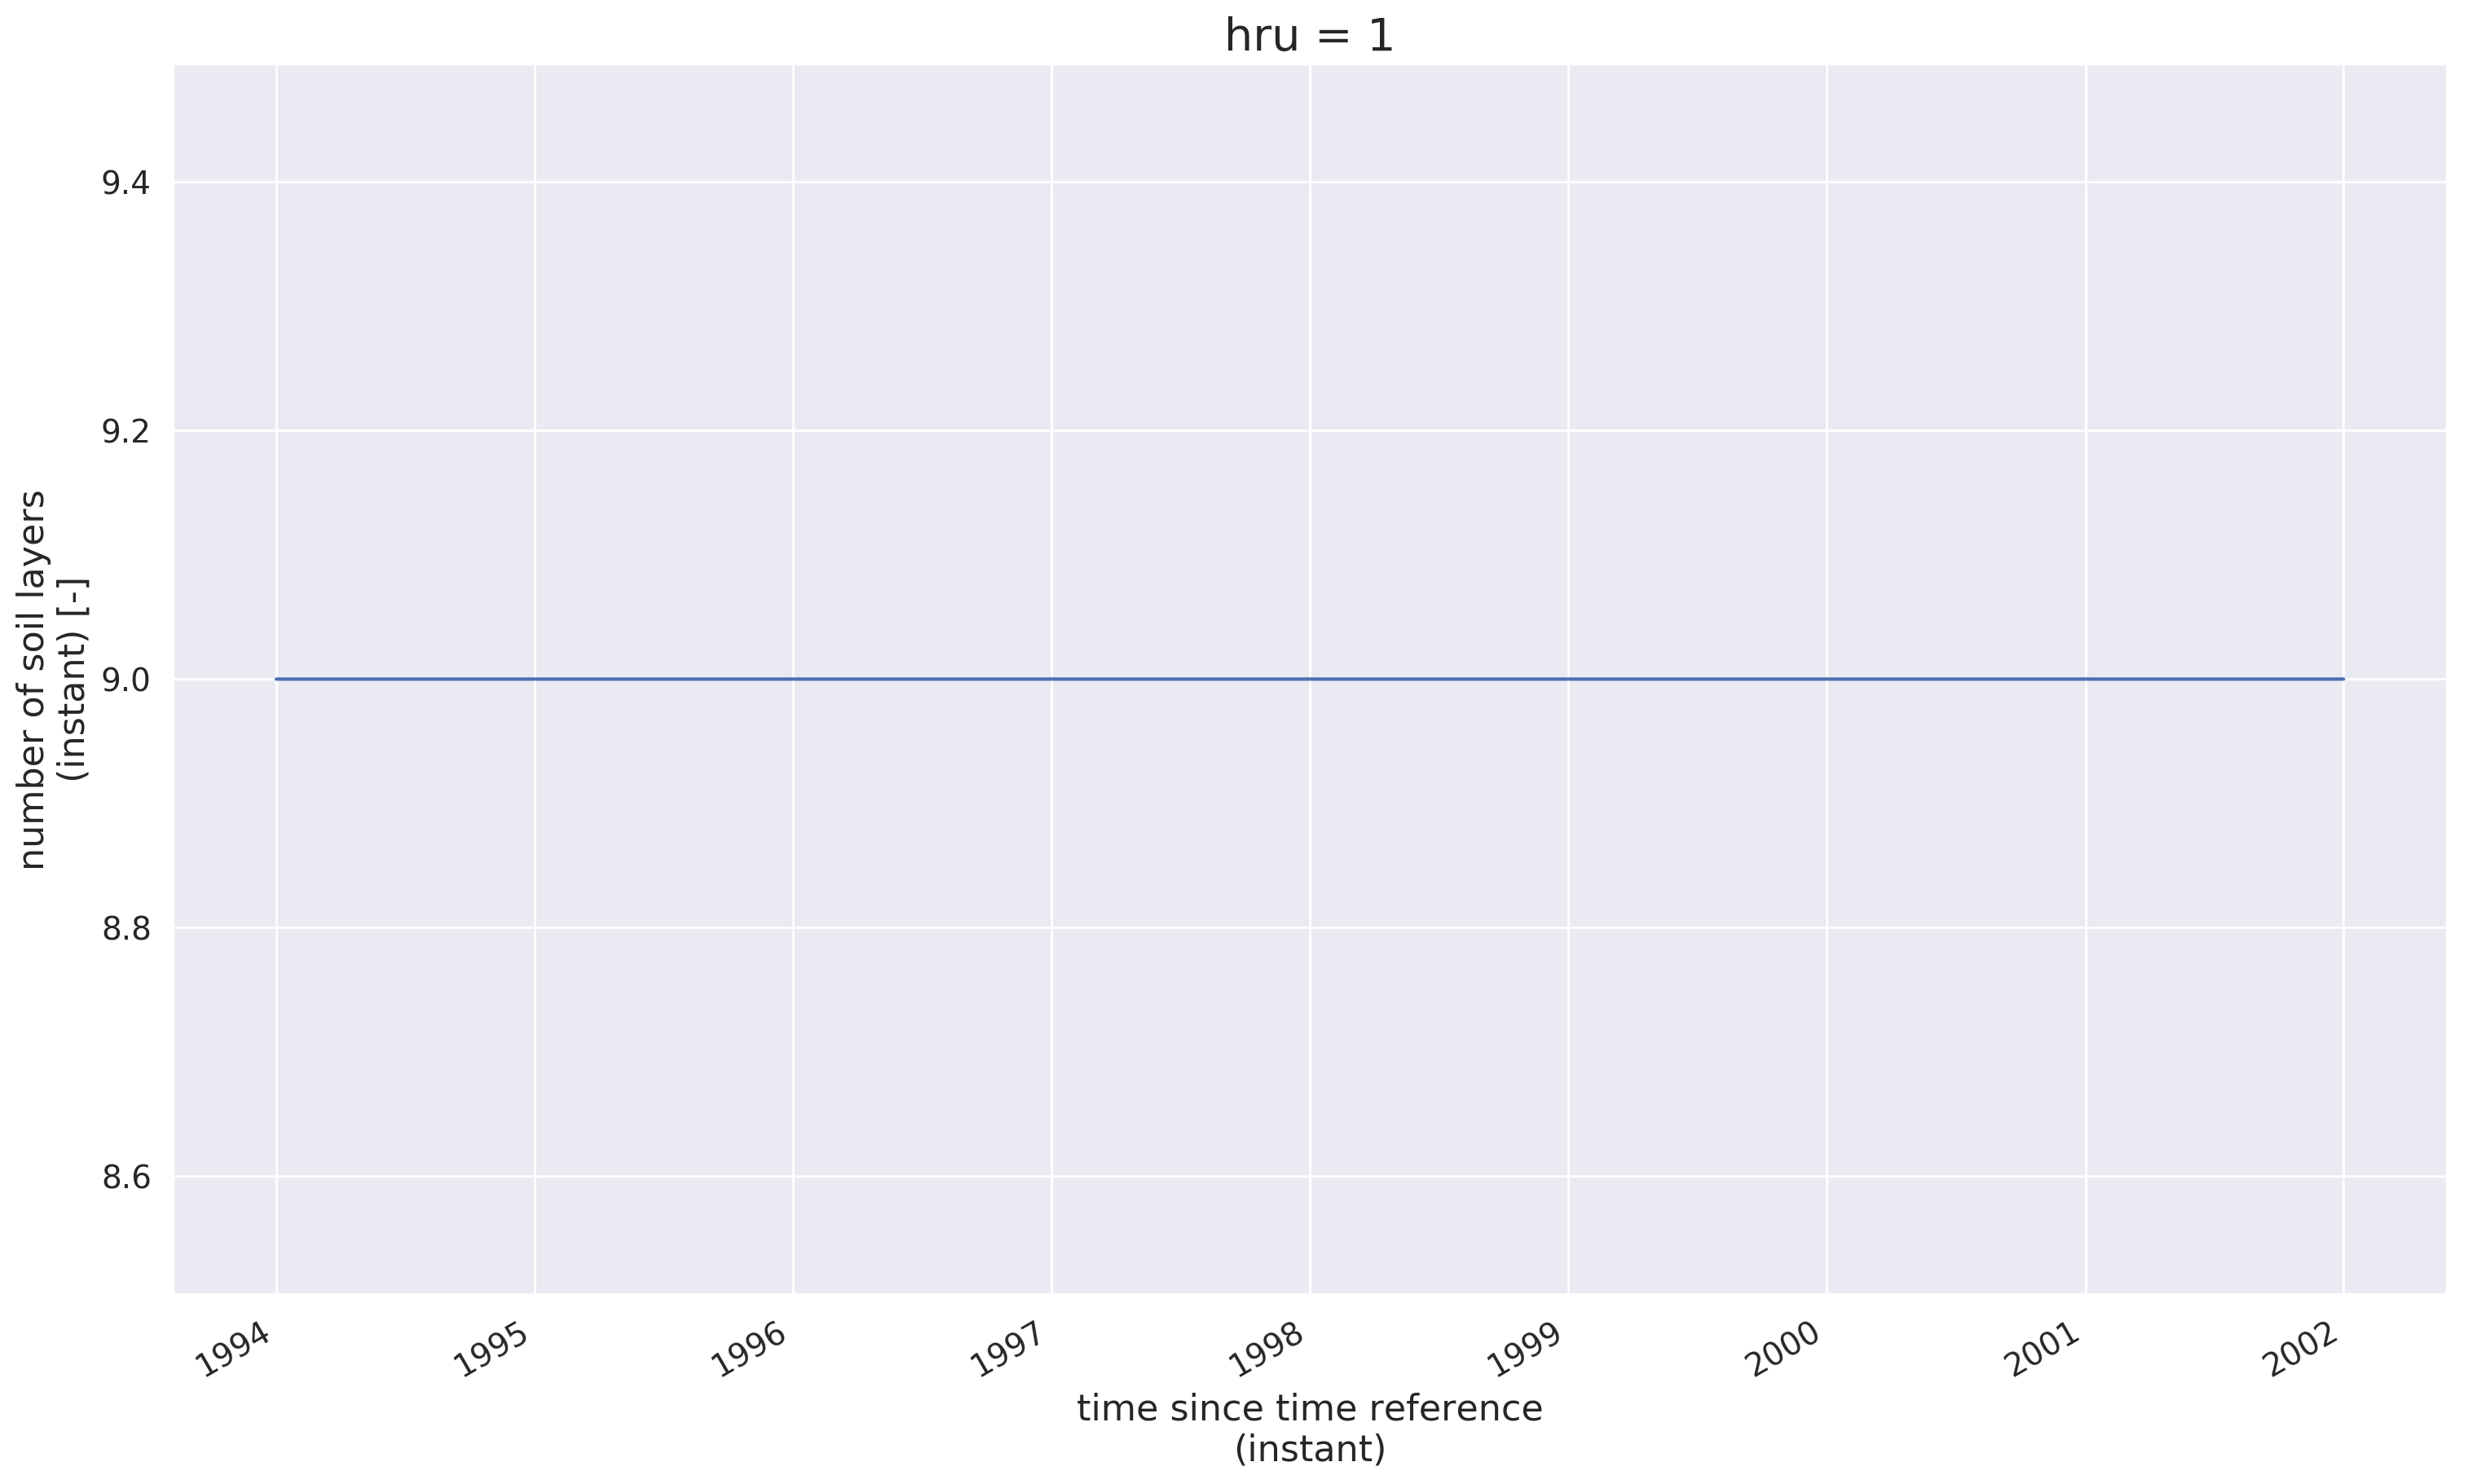

In [13]:
S.output.nSoil.plot()

and the soil moisture in the bottom soil layer is:

Text(0, 0.5, 'Volumetric fraction of total water in bottom soil layer (-)')

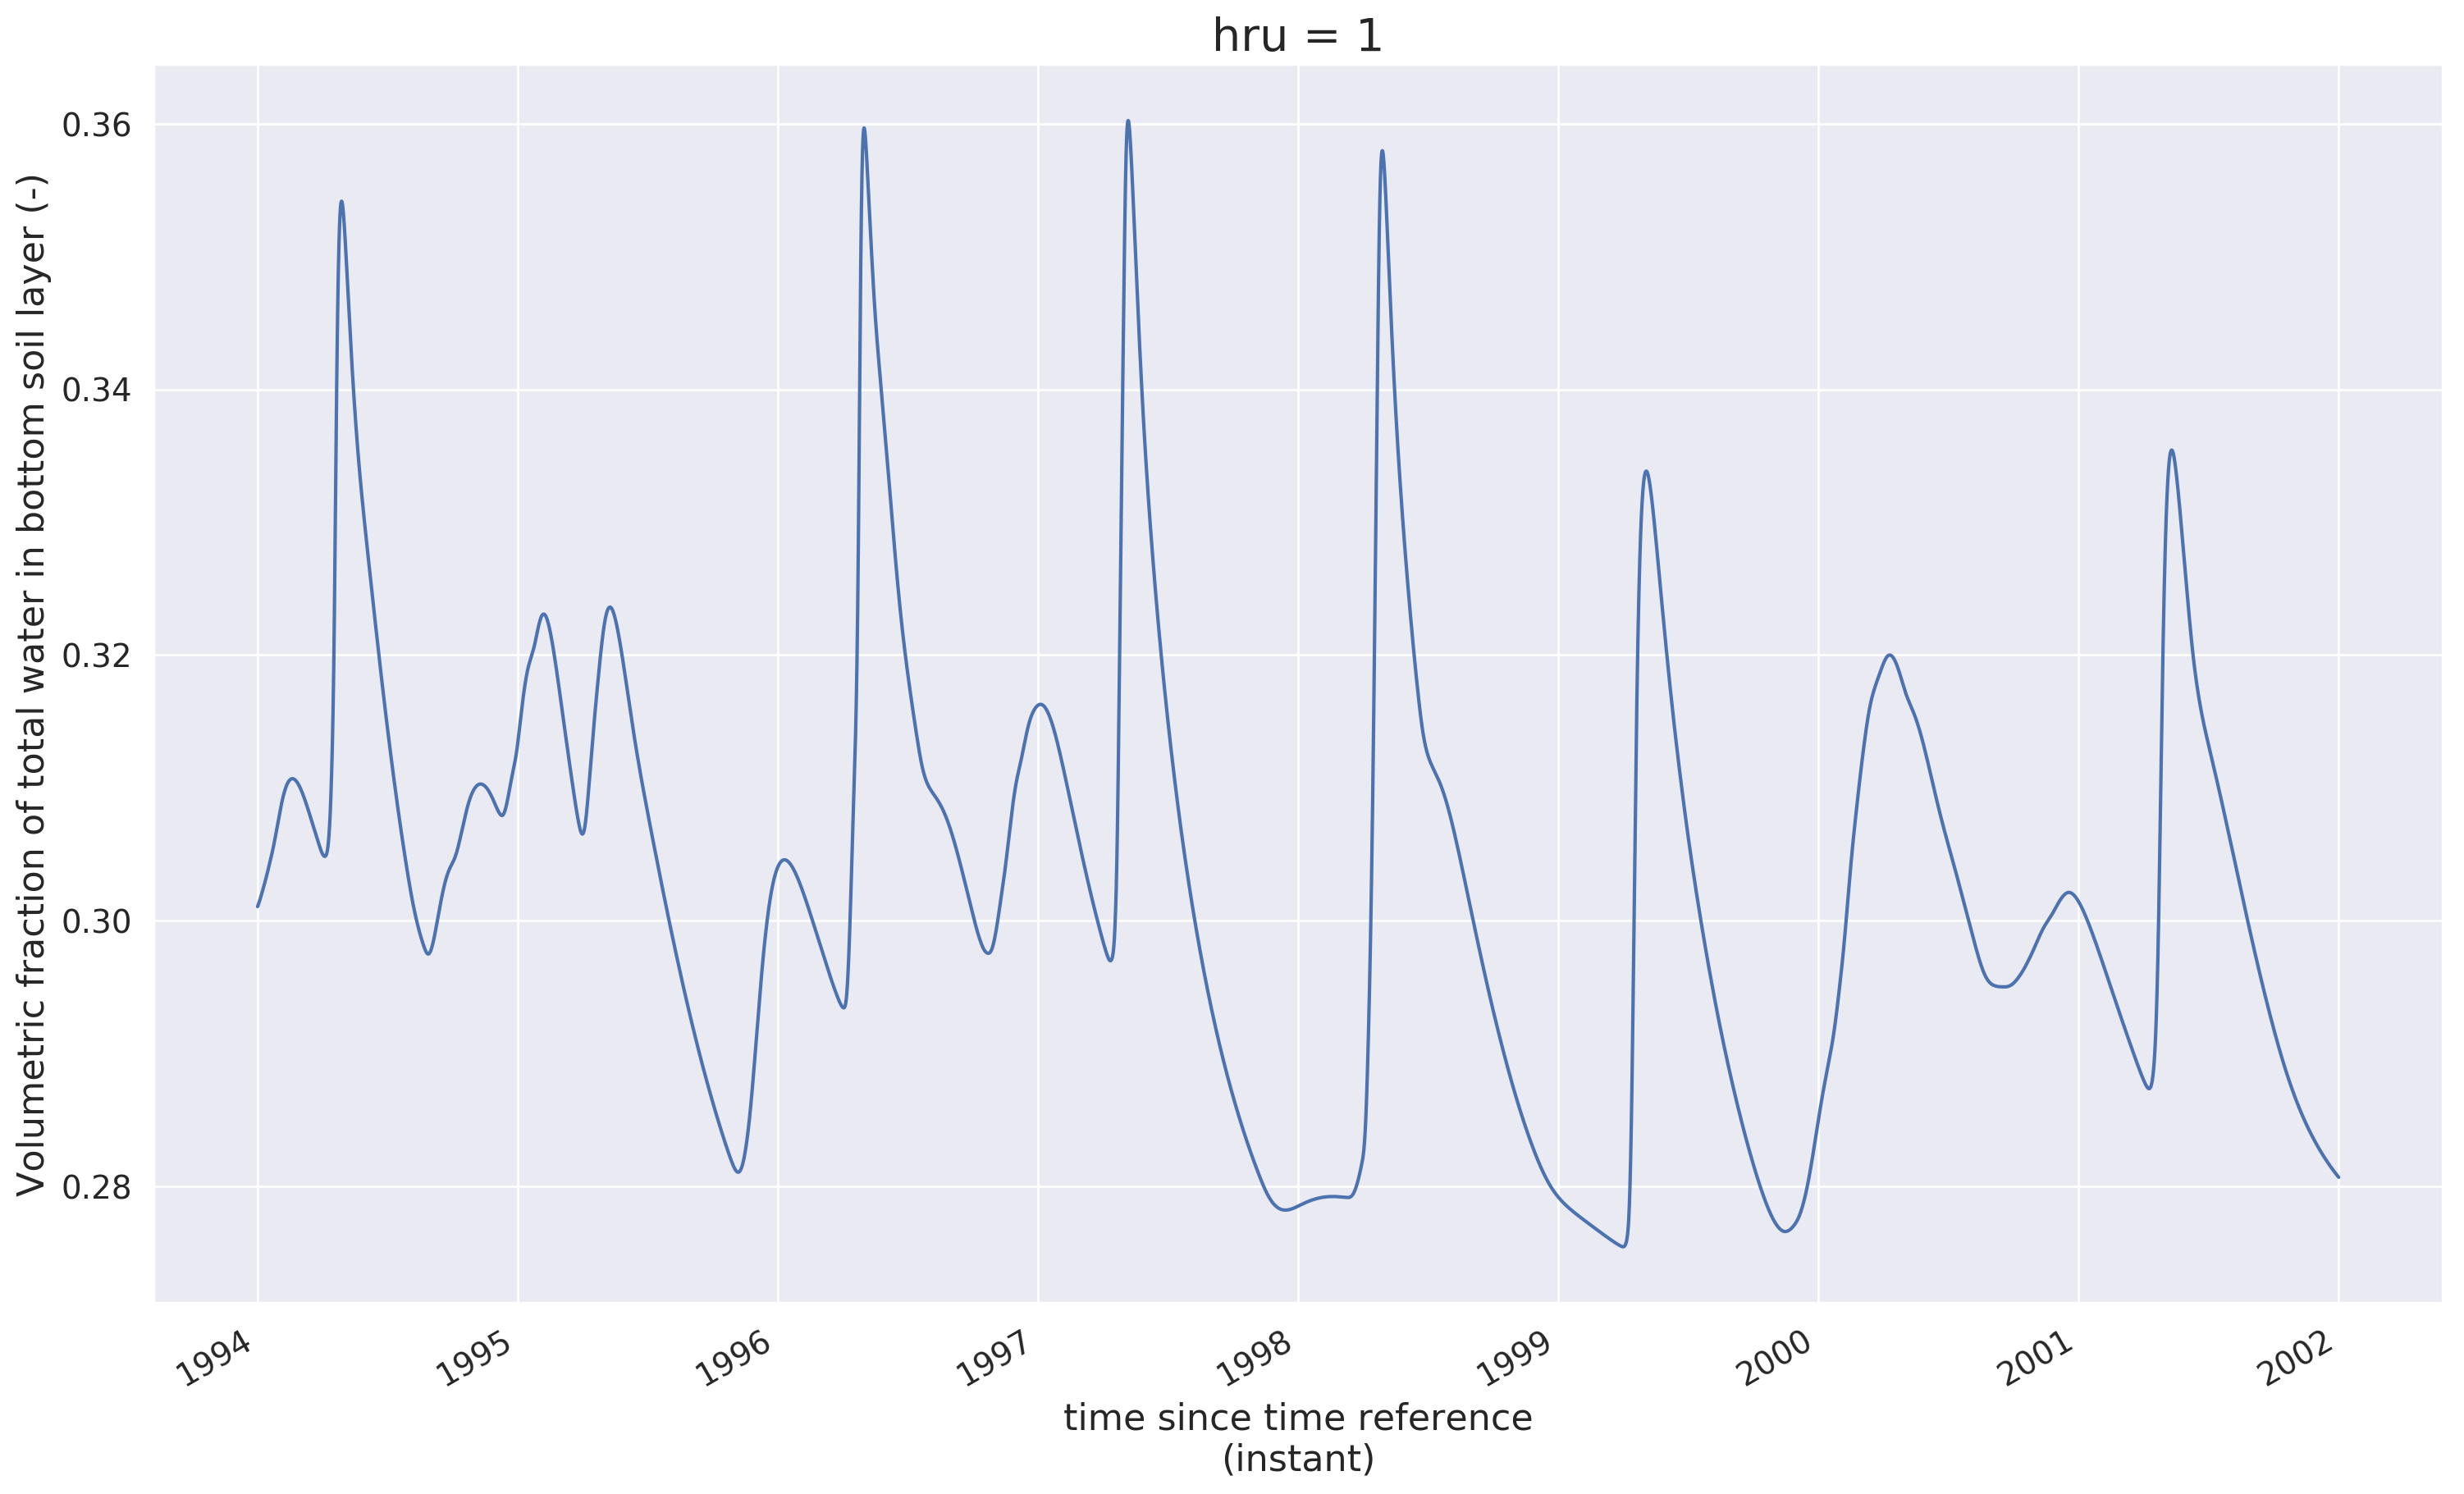

In [14]:
soil_layer = 8 # bottom soil layer
snow_layers = S.output.nSnow
toto_layer = soil_layer + snow_layers
S.output.mLayerVolFracWat[:,toto_layer].plot()
plt.ylabel('Volumetric fraction of total water in bottom soil layer (-)')

As expected, the soil moisture changes much more slowly in the bottom soil layer. All in one plot:

Text(0, 0.5, 'Volumetric fraction of total water in each soil layer (-)')

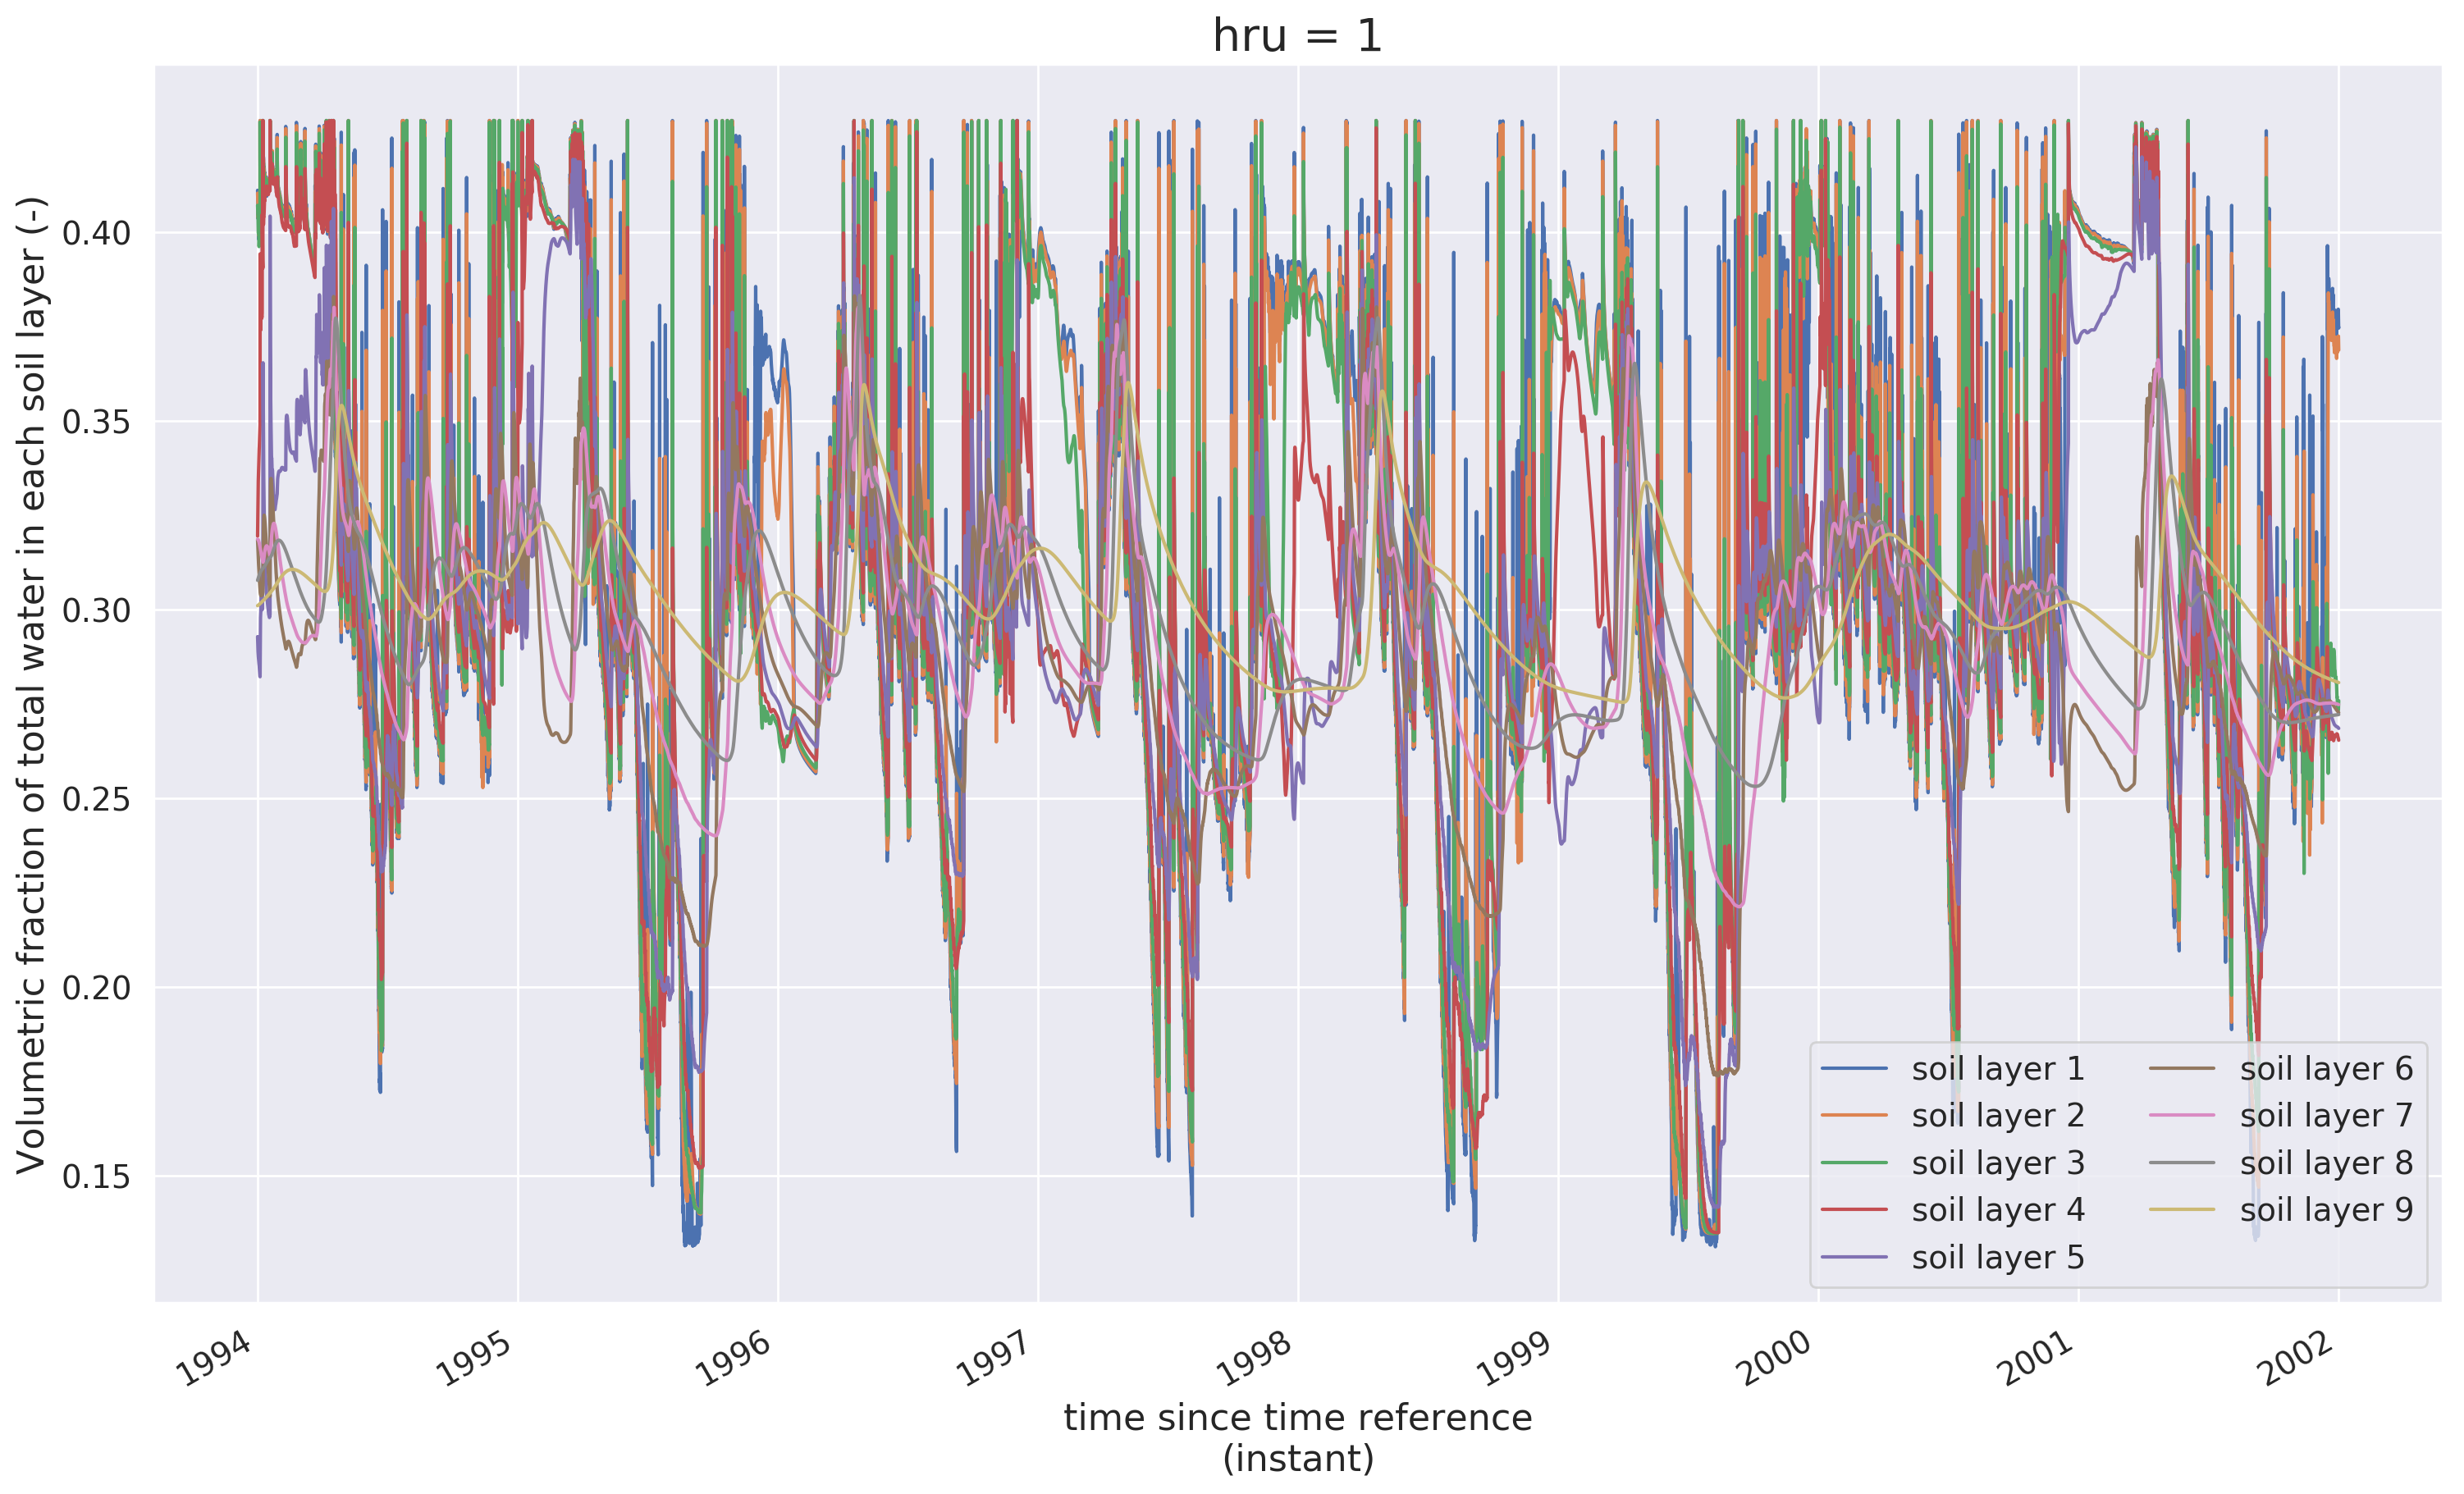

In [15]:
snow_layers = S.output.nSnow
for i in range(9):
    toto_layer = i + snow_layers
    S.output.mLayerVolFracWat[:,toto_layer].plot(label="soil layer {}".format(i+1))
plt.legend(ncol=2)
plt.ylabel('Volumetric fraction of total water in each soil layer (-)')

Not a great plot. As said, I will share a code snippet to make this a lot more informative (as a 2-D plot).

## Reading from file

You don't have to rerun the model everytime. Once you have run the model, you can simply read in a file you already created (or one of the other NetCDF files with observations). Because NetCDF files have their own metadata, you can simply use `xr.open_dataset()` to open an existing file. For example, we can read the observations for the Harvard site:

In [16]:
Harvard_obs_file = '/home/jovyan/PLUMBER_data/sites/Harvard/observations/fluxes/HarvardFluxnet.1.4_flux.nc'
ds_obs = xr.open_dataset(Harvard_obs_file)

and to get the context, just type

In [17]:
ds_obs

<xarray.Dataset>
Dimensions:           (time: 140256, x: 1, y: 1)
Coordinates:
  * x                 (x) float64 1.0
  * y                 (y) float64 1.0
  * time              (time) datetime64[ns] 1994-01-01T00:30:00 ... 2002-01-01
Data variables:
    latitude          (y, x) float32 ...
    longitude         (y, x) float32 ...
    Qle               (time, y, x) float32 ...
    Qh                (time, y, x) float32 ...
    NEE               (time, y, x) float32 ...
    GPP               (time, y, x) float32 ...
    Rnet              (time, y, x) float32 ...
    Qle_qc            (time, y, x) float32 ...
    Qh_qc             (time, y, x) float32 ...
    NEE_qc            (time, y, x) float32 ...
    GPP_qc            (time, y, x) float32 ...
    Rnet_qc           (time, y, x) float32 ...
    elevation         (y, x) float32 ...
    reference_height  (y, x) float32 ...
Attributes:
    Production_time:                  2012-09-27 12:02:14
    Production_source:                PALS aut

Reading a previous model output file works the same way.

## Exporting to ASCII (csv)

While python and Jupyter notebooks are very powerful, I also realize that you may already have different analysis tools that you want to use. I am fine with that for the purpose of the class project, so here is a brief example of how you can export data to csv so it can be read into other programs that are not NetCDF-aware (e.g. excel).

Let's first write a single scalar variable to a csv file. For example, the latent heat flux: 

In [18]:
S.output.scalarLatHeatTotal.to_pandas().to_csv('/home/jovyan/PLUMBER_data/sites/Harvard/summa_output/latent_heat.csv')

If you want to output the soil moisture, one way for now is to just write out one layer at a time, e.g.

In [19]:
soil_layer = 8 # bottom soil layer
snow_layers = S.output.nSnow
toto_layer = soil_layer + snow_layers
S.output.mLayerVolFracWat[:,toto_layer].to_pandas().to_csv('/home/jovyan/PLUMBER_data/sites/Harvard/summa_output/soil_moisture_bottom_layer.csv')